In [1]:
import sys, os, re
from typing import *
sys.path = (["../src/", "../"] if re.match(r"^(\w\:\\)|(/)", os.getcwd()) else []) + sys.path
import qubx
%qubxd

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.basics import DataType, Instrument, Signal, TimestampedDict
from qubx.core.interfaces import IStrategy, IStrategyContext, TriggerEvent, MarketEvent
from qubx.core.series import Bar, Quote, Trade, OrderBook
from qubx.data.readers import InMemoryDataFrameReader, DataReader, AsDict, AsTrades, AsOhlcvSeries, AsBars, AsQuotes, AsTimestampedRecords, AsPandasFrame,RestoreTicksFromOHLC, RestoredBarsFromOHLC
from qubx.backtester.utils import _StructureSniffer
from qubx.core.metrics import tearsheet, chart_signals
from qubx.pandaz.utils import *
import qubx.ta.indicators as ta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.data.helpers import loader
from qubx.backtester.simulator import simulate

ld = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


### <s>Current approach </s>

In [6]:
class TestA(IStrategy):
    """ Document your strategy here """
    timeframe: str = "15Min"
    exchange = 'BINANCE.UM'

    def on_init(self, ctx: IStrategyContext):
        ctx.set_base_subscription(DataType.OHLC[self.timeframe])
        ctx.set_event_schedule("55 23 * * *")
        ctx.set_fit_schedule("50 23 * * 1")
        self._idx = 0
        self._to_test = [
            [self.find_instrument(s) for s in ["BTCUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "BCHUSDT", "LTCUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "AAVEUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BCHUSDT"]],
        ]

    def on_fit(self, ctx: IStrategyContext):
        logger.info(f" -> subscribe : {self.lst(self._to_test[self._idx])}")
        ctx.set_universe(self._to_test[self._idx])
        self._idx += 1
        if self._idx >= len(self._to_test):
            self._idx = 0 

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> Optional[List[Signal]]:
        s = []
        logger.info(f"Trig: {self.lst(ctx.instruments)} --> {str({i.symbol: ctx.quote(i) for i in ctx.instruments})}")
        if 1:
            for i in ctx.instruments:
                data = ctx.ohlc(i, self.timeframe)
                s1 = ta.kama(data.close, 36) - ta.kama(data.close, 12)
                if len(s1) > 1:
                    if s1[1] < 0 and s1[0] > 0:
                        logger.info(f"BUY: {i}")
                        s.append(ctx.instruments[0].signal(+1))

                    if s1[1] > 0 and s1[0] < 0:
                        logger.info(f"SELL: {i}")
                        s.append(i.signal(-1))
        return s

    def find_instrument(self, symbol: str) -> Instrument:
        return lookup.find_symbol(self.exchange, symbol) # type: ignore

    def lst(self, instrs: list[Instrument]):
        return ','.join(map(lambda x: x.symbol, instrs))


In [ ]:
r = simulate(
   # {'A': TestA(timeframe="1h")}, ld, 1000, 
   variate(TestA, timeframe=["15Min", "30Min", "1h"]), ld, 1000, 
   ['BINANCE.UM:BTCUSDT'],
   "vip0_usdt", "2023-07-01", "2023-07-30", debug="DEBUG"
)

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,TA_(t=15Min),-659.24220,-0.999998,3.041389,-0.574773,106.709664,2215.990000,14.924458,-1.114604,2.524995,0.291326,1328.670529,14.507123,30.51720,4.0
2,TA_(t=1h),-668.58825,-0.999999,3.020462,-0.590899,106.811806,2220.000000,14.826988,-1.114604,2.536118,0.305066,1330.357952,14.414770,30.68325,4.0
1,TA_(t=30Min),-27.31788,-0.286085,-3.623893,-0.144373,4.877510,48.775097,-4.355597,-10.472455,0.000000,0.193378,8.682623,-0.091148,1.94288,2.0


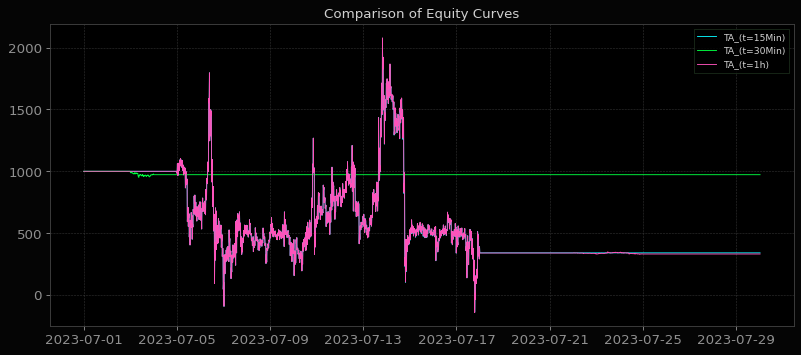

In [4]:
tearsheet(r, False, use_plotly=False)

In [5]:
r[2].config()

"TestA(timeframe='1h', exchange='BINANCE.UM')"

In [ ]:
# chart_signals(r[0], 'BTCUSDT', ld[['BTCUSDT']], show_signals=True)

## <font color='#00ff00'>-> New approach</font>

In [2]:
# - real data from CSV
l1 = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)

# - 'real' quotes provider
rnd = lambda n: np.random.randn(n)  # noqa: E731
idx = pd.date_range(start="2023-06-01 00:00", end="2023-07-30", freq="5Min", name="timestamp")
q_data = pd.DataFrame({"bid": rnd(len(idx)), "ask": rnd(len(idx)), "bid_vol": rnd(len(idx)), "ask_vol": rnd(len(idx)) }, index=idx)
qts_reader = InMemoryDataFrameReader({"BINANCE.UM:BTCUSDT": q_data})

# - any data provider
idx = pd.date_range(start="2023-06-01 00:00", end="2023-07-30", freq="1h", name="timestamp")
c_data = pd.DataFrame({"value1": rnd(len(idx)), "value2": rnd(len(idx))}, index=idx)
custom_reader = InMemoryDataFrameReader({"BINANCE.UM:BTCUSDT": c_data})

In [3]:
class TestB(IStrategy):
    ma_period: str = "15Min"
    apply_own_schedule = False
    show_mkt = False

    def on_init(self, ctx: IStrategyContext):
        if self.apply_own_schedule: ctx.set_event_schedule("0 */1 * * *")

    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent) -> list[Signal] | Signal | None:
        if self.show_mkt:
            logger.info(f'{data.instrument.symbol} market event ::: <g>{data.type}</g>\t:::  -> {data.data}')

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal] | None:
        s = []
        if 0:
            logger.info('<r> === Event ===</r>')
            return s

        for i in ctx.instruments:
            data = ctx.ohlc(i, self.ma_period, 100)
            s1 = ta.kama(data.close, 12) - ta.kama(data.close, 3)
            if len(s1) > 1:
                if s1[1] < 0 and s1[0] > 0:
                    logger.info(f" >> BUY: {i}")
                    s.append(i.signal(+1))

                if s1[1] > 0 and s1[0] < 0:
                    logger.info(f"SELL: {i}")
                    s.append(i.signal(-1))
        return s

In [ ]:
CFGS = [

   l1,                                     # 0 - just reader

   l1[['BTCUSDT'], "2023-06-01":"now"],    # 1 - as dict with dataframes

   {'ohlc': l1},                           # 2 - as specified ohlc

   {'ohlc(4h)': l1},                       # 3 - as 4h - we want to get triggers on 4h bars close

   {'ohlc(6h)': l1[['BTCUSDT']] },         # 4 - as 6h from predefined data

   {                                       # 5 - ohlc + real quotes / trades + custom data
      'ohlc(1h)': l1,                     
      'trade': l1, 
      'quote': l1, 
      # '<y>quote1</y>': qts_reader, 
      # '<r>MY_DATA</r>': custom_reader
    },
]

r = simulate({'CrossOver MA': TestB(show_mkt=0, apply_own_schedule=0, ma_period="1h")}, 

   CFGS[5],

   1000, ['BINANCE.UM:BTCUSDT', 'BINANCE.UM:ETHUSDT'], 
   # 1000, ['BINANCE.UM:ETHUSDT'], 
   "vip0_usdt", "2023-07-01", "2023-07-30", debug="DEBUG",
   enable_event_batching=False
)

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
CrossOver MA,858.134,1877.327,-2.182,0.323,156.896,2113.428,-2.884,1696.665,0.794,0.049,2342.911,-15.458,1528.821,85.0


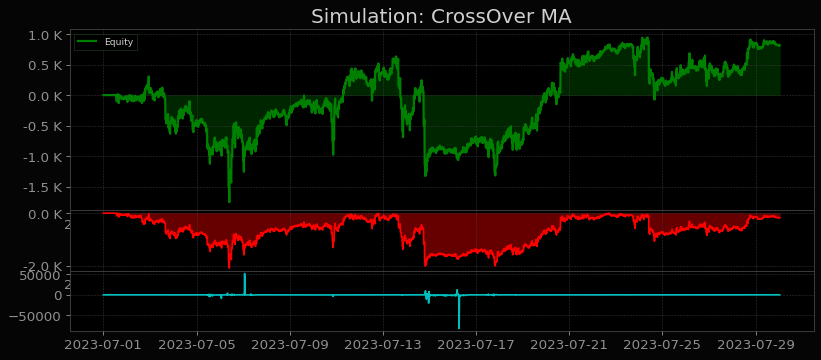

In [5]:
tearsheet(r, False, plot_leverage=1)


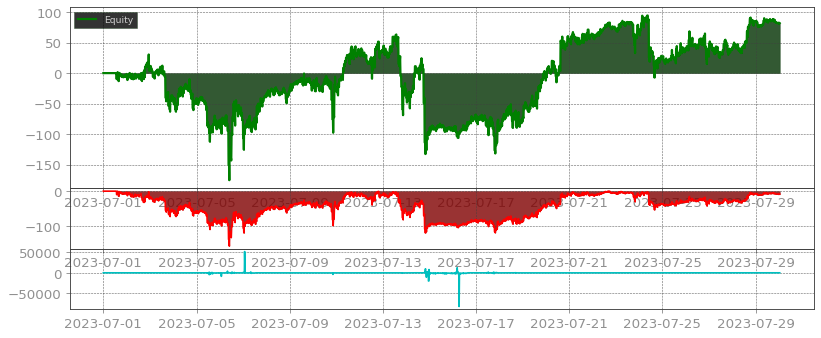

In [67]:
r[0].to_html()

In [ ]:
r[0].to_file("test")

In [ ]:
chart_signals(r[0], 'BTCUSDT', l1[['BTCUSDT']], show_signals=True, show_trades=True)

In [ ]:
r[0].portfolio_log

## Triggering time

In [6]:
class TestC(IStrategy):
    apply_own_schedule = False
    show_mkt = False

    def on_init(self, ctx: IStrategyContext):
        if self.apply_own_schedule: 
            ctx.set_event_schedule("0 */1 * * *")
        # ctx.set_warmup({
        #     DataType.OHLC['1h']: '1d'
        # })

    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent) -> list[Signal] | Signal | None:
        if self.show_mkt:
            logger.info(f'{data.instrument.symbol} market event ::: <g>{data.type}</g>\t:::  -> {data.data}')

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal] | None:
        s = []

        # for i in ctx.instruments:
            # data = ctx.ohlc(i, '1h', 100)
            # logger.info(data)
        if 1: logger.info('<r> === Event ===</r>')
        return s

In [7]:
r = simulate({'A': (stg:=TestC(show_mkt=0, apply_own_schedule=0))}, 
   # qts_reader,
   {
      'ohlc(4h)': l1, 
      'trade': l1, 
      # 'quote': l1, 
      # 'quote': qts_reader, 
   #    # '<y>quote1</y>': qts_reader, 
      '<r>MY_DATA</r>': custom_reader
    },

   1000, ['BINANCE.UM:BTCUSDT', 'BINANCE.UM:ETHUSDT' ], 
   "vip0_usdt", "2023-07-01", "2023-07-03", debug="DEBUG", 
   enable_event_batching=1
)

2023-07-30 00:59:59.000 [🐞] TestC new parameters:
	set show_mkt <- 0
	set apply_own_schedule <- 0


2024-12-23 16:21:40.259 [ 🐞 ] (simulator) 2023-07-01 00:00:00 Initiating simulated trading for binance.um for 1000 x 1.0 in USDT...
2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider.binance.um is initialized
2023-07-01 00:00:00.000 [🐞]  | Setting up default base subscription: ohlc(1h)
2023-07-01 00:00:00.000 [🐞]  | Setting default schedule: 0 */4 * * *
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments __all__ -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscriptions None -> []


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(1h) -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(1h) -> []
2023-07-01 00:00:00.000 [🐞]  | subscribe: ohlc(1h) -> {BINANCE.UM:SWAP:ETHUSDT, BINANCE.UM:SWAP:BTCUSDT}
2023-07-01 00:00:00.000 [🐞]  | Subscribing to: ohlc_trades
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc_trades -> []
2023-07-01 00:00:00.000 [🐞]  | Subscribing to: MY_DATA
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments MY_DATA -> []
2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider ::: Simulation started at 2023-07-01 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.1h 2023-07-01 00:00:00 : 2023-07-03 00:00:00 ...
2023-07-01 00:00:01.000 [🐞] Invoking TestC on_fit
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments None -> [BINANCE.UM:SWAP:ETHUSDT, BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_ins

2023-07-02 20:00:01.000 [ℹ️]  === Event ===
2023-07-03 00:00:01.000 [ℹ️]  === Event ===
2023-07-03 00:59:59.000 [ℹ️] SimulatedDataProvider ::: Simulation finished at 2023-07-03 00:00:00 :::


In [ ]:
r[0].to_html()

In [31]:
r[0].to_file("Test2")

<Figure size 960x400 with 0 Axes>

In [33]:
str(r[0].creation_time)

'2024-12-19 15:35:56.545740'

In [ ]:
tearsheet(r[0], plot_leverage=1)